# LSTM Autoencoder for Rare Event Binary Classification

This is a continuation of the regular autoencoder for rare event classification presented in
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
and code present in
https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb
Here we will show an implementation of building a binary classifier using LSTM Autoencoders. 
Similar to the previous post, the purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

LSTM requires closer attention to preparing the data. Here we have all the steps, and few tests to validate the data preparation.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [272]:
%matplotlib inline
from yapf.yapflib.yapf_api import FormatCode
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from imblearn.over_sampling import SMOTE
from collections import Counter

from numpy.random import seed
seed(1)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

SEED = 123  #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

In [165]:
sign = lambda x: (1, -1)[x < 0]


def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol + 'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol + 'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [206]:
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives',
                                               initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Arguments:
        y_true  The actual y. Passed by default to Metric classes.
        y_pred  The predicted y. Passed by default to Metric classes.
        
        '''
        # Compute the number of negatives.
        y_true = tf.cast(y_true, tf.bool)

        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))

        self.negatives.assign_add(negatives)

        # Compute the number of false positives.
        y_pred = tf.greater_equal(
            y_pred, 0.5
        )  # Using default threshold of 0.5 to call a prediction as positive labeled.

        false_positive_values = tf.logical_and(tf.equal(y_true, False),
                                               tf.equal(y_pred, True))
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)

        false_positives = tf.reduce_sum(false_positive_values)

        self.false_positives.assign_add(false_positives)

    def result(self):
        return tf.divide(self.false_positives, self.negatives)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.actual_positives = self.add_weight(name='actual_positives',
                                                initializer='zeros')
        self.predicted_positives = self.add_weight(name='predicted_positives',
                                                   initializer='zeros')
        self.true_positives = self.add_weight(name='true_positives',
                                              initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Arguments:
        y_true  The actual y. Passed by default to Metric classes.
        y_pred  The predicted y. Passed by default to Metric classes.
        
        '''
        # Compute the number of negatives.
        y_true = tf.cast(y_true, tf.bool)

        actual_positives = tf.reduce_sum(
            tf.cast(tf.equal(y_true, True), self.dtype))
        self.actual_positives.assign_add(actual_positives)

        # Compute the number of false positives.
        y_pred = tf.greater_equal(
            y_pred, 0.5
        )  # Using default threshold of 0.5 to call a prediction as positive labeled.

        predicted_positives = tf.reduce_sum(
            tf.cast(tf.equal(y_pred, True), self.dtype))
        self.predicted_positives.assign_add(predicted_positives)

        true_positive_values = tf.logical_and(tf.equal(y_true, True),
                                              tf.equal(y_pred, True))
        true_positive_values = tf.cast(true_positive_values, self.dtype)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(true_positive_values, sample_weight)

        true_positives = tf.reduce_sum(true_positive_values)

        self.true_positives.assign_add(true_positives)

    def result(self):
        recall = tf.math.divide_no_nan(self.true_positives, self.actual_positives)
        precision = tf.math.divide_no_nan(self.true_positives, self.predicted_positives)
        f1_score = 2 * tf.math.divide_no_nan(tf.multiply(recall, precision),
                                             tf.math.add(recall, precision))
        
        return f1_score

In [262]:
def telu(x, threshold=0.1):
    '''
    Thresholded Exponential linear unit.
      Arguments:
      x: Input tensor.
      alpha: A scalar = 1.6732632, slope of negative section.
      scale: A scalar = 1.05070098, to keep the gradient > 1 for x > 0.
      Returns:
      The thresholded exponential linear activation: `x` if `scale * x > threshold` and
        `scale * alpha * (exp(x)-1)` if `x < -threshold`.
    '''
    x_ = tf.keras.activations.selu(x)
    threshold_ = tf.math.scalar_mul(threshold, K.ones_like(x_))  # Creates a tensor of same shape as x with the threshold in each cell.
    threshold_multiplier = K.cast(K.less(threshold_, K.abs(x_)), dtype='float32')  # Creates an identity tensor which is one if the abs(x) > threshold.
    
    return tf.math.multiply(x_, threshold_multiplier)

In [231]:
def plot_metric(model_history, metric, ylim=None):
    train_loss = [
        value for key, value in model_history.items() if metric in key.lower()
    ][0]
    valid_loss = [
        value for key, value in model_history.items() if metric in key.lower()
    ][1]

    fig, ax = plt.subplots()

    color = 'tab:blue'
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel(metric, color=color, fontsize=16)
    if ylim is not None:
        ax.set_ylim([ylim[0] - 0.05, ylim[1] + 0.05])
    ax.plot(train_loss, '--', color=color, label='Train ' + metric)
    ax.plot(valid_loss, color=color, label='Valid ' + metric)
    ax.tick_params(axis='y', labelcolor=color)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='upper left', fontsize=16)
    plt.title('Model ' + metric, fontsize=16)

    return plt, fig


def plot_model_recall_fpr(model_history):
    train_recall = [
        value for key, value in model_history.items()
        if 'recall' in key.lower()
    ][0]
    valid_recall = [
        value for key, value in model_history.items()
        if 'recall' in key.lower()
    ][1]

    train_fpr = [
        value for key, value in model_history.items()
        if 'false_positive_rate' in key.lower()
    ][0]
    valid_fpr = [
        value for key, value in model_history.items()
        if 'false_positive_rate' in key.lower()
    ][1]

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch', fontsize=16)
    ax1.set_ylabel('Recall', color=color, fontsize=16)
    ax1.set_ylim([-0.05, 1.05])
    ax1.plot(train_recall, '--', color=color, label='Train Recall')
    ax1.plot(valid_recall, color=color, label='Valid Recall')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='upper left', fontsize=16)
    plt.title('Model Recall and FPR', fontsize=16)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('False Positive Rate', color=color,
                   fontsize=16)  # we already handled the x-label with ax1
    ax2.plot(train_fpr, '--', color=color, label='Train FPR')
    ax2.plot(valid_fpr, color=color, label='Valid FPR')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_ylim([-0.05, 1.05])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend(loc='upper right', fontsize=16)

    return plt, fig

In [168]:
tf.__version__

'2.0.0-beta0'

## Reading and preparing data

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [3]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

,DateTime,SheetBreak,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,...,1PrsTopSpd,4PrsBotSpd,WtNStarFlo,BasWgtFlo,TMP Flow,HBxTotHead,TrayCons,UpprHdTmpRL,VertSlcPos,EventPress
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230658,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


## Convert Categorical column to Dummy

There are two categorical columns that we will transfor to one-hot encoding.

- Grade&Bwt
- EventPress

In [4]:
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df = df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df = pd.concat([df, hotencoding1, hotencoding2], axis=1)

## Rename response column name for ease of understanding

In [5]:
df = df.rename(columns={'SheetBreak': 'y'})

### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [7]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by=-2)

In [8]:
# Remove time column, and the categorical columns
df = df.drop(['DateTime'], axis=1)

# Prepare data for LSTM models

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [9]:
input_X = df.loc[:, df.columns != 'y'].values  # converts df to numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [10]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(input_X[[(i + j + 1)], :])
        X.append(t)
        y.append(input_y[i + lookback + 1])
    return X, y

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the `temporalize` function with a `lookback`. For the modeling, we may use a longer lookback.

In [11]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0] -
                 5):(np.where(np.array(input_y) == 1)[0][0] + 1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)

print('For the same instance of y = 1, \
      we are keeping past 5 samples in \
      the 3D predictor array, X.')
display(
    pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0)))

First instance of y = 1 in the original data


,y,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,C1 BW SPREAD MD,...,grade_51,grade_82,grade_84,grade_93,grade_96,grade_112,grade_118,grade_139,eventpress_0,eventpress_1
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,0,0,0,0,1,0,0,0,1,0
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000060,-0.051043,-0.040129,...,0,0,0,0,1,0,0,0,1,0
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,0,0,0,0,1,0,0,0,1,0
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,0,0,0,0,1,0,0,0,1,0
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,0,0,0,0,1,0,0,0,1,0
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,0,0,0,0,1,0,0,0,1,0


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000060,-0.051043,-0.040129,0.001791,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,0.001791,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


The two tables are the same. This testifies that we are correctly taking 3 samples (= lookback), X(t):X(t-3) to predict y(t).

### Divide the data into train, valid, and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

In [13]:
X_train.shape

(13002, 5, 1, 69)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [14]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [15]:
X_train.shape

(13002, 5, 69)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature. 

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

- `flatten`: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of `temporalize`, meaning `X = flatten(temporalize(X))`.
- `scale`: This function will scale a 3D array that we created as inputs to the LSTM.

In [16]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty(
        (X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return flattened_X


def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])

    return X

In [17]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

X_train_scaled = scale(X_train, scaler)

In [19]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
print('colwise mean', np.mean(flatten(X_train_scaled), axis=0).round(6))
print('colwise variance', np.var(flatten(X_train_scaled), axis=0))

colwise mean [-0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0.
 -0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.
  0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0.
  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


The test succeeded. Now we will _scale_ the validation and test sets.

In [20]:
X_valid_scaled = scale(X_valid, scaler)
X_test_scaled = scale(X_test, scaler)

## LSTM Classifier training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

### Model 1.1. Baseline

In [182]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(
    LSTM(8, activation='relu', return_sequences=False, name='lstm_layer_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 8)                 800       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 6,313
Trainable params: 6,313
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy',
                     tf.keras.metrics.Recall(),
                     F1Score(),
                     FalsePositiveRate()]
           )

In [186]:
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

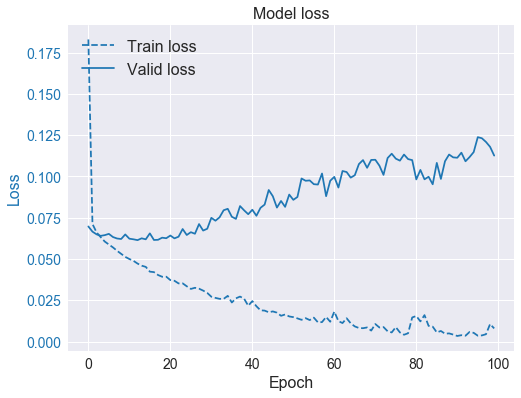

In [151]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

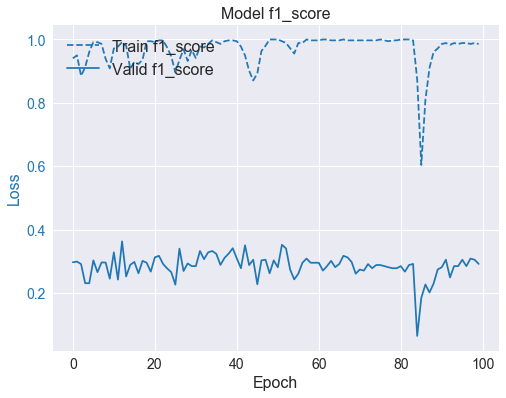

In [187]:
plt, fig = plot_metric(history, metric='f1_score')
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

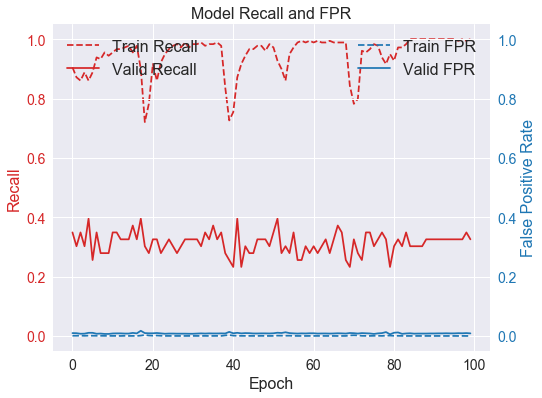

In [180]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 1.2. Baseline + Time Distributed

In [191]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_2'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_10 (Flatten)         (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

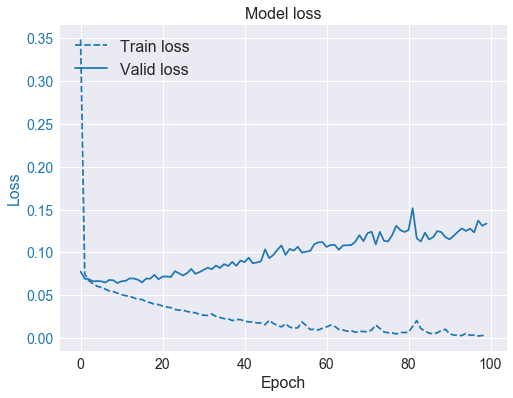

In [193]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

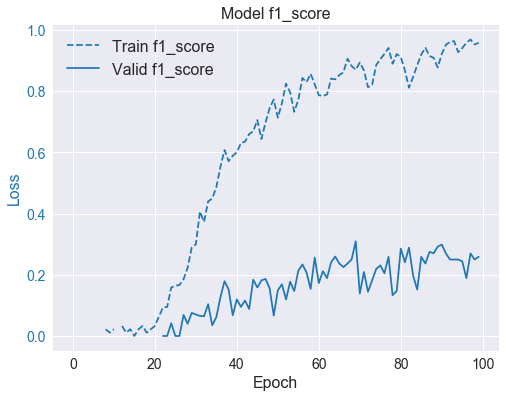

In [194]:
plt, fig = plot_metric(history, metric='f1_score')
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

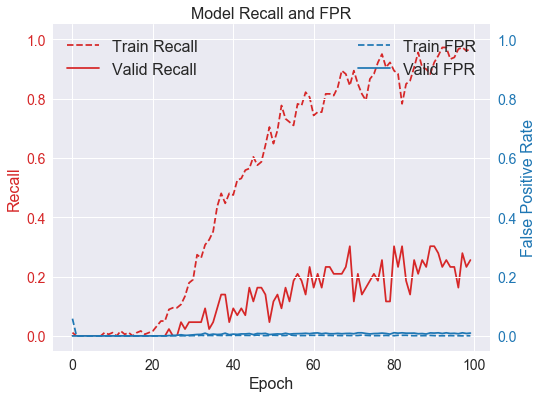

In [195]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

## Improvements

### 2.1. Dropout + return_sequences=False

In [207]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_13 (Flatten)         (None, 40)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
___________________________________________________

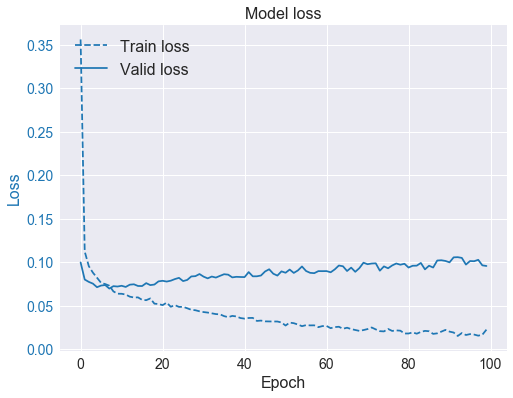

In [208]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

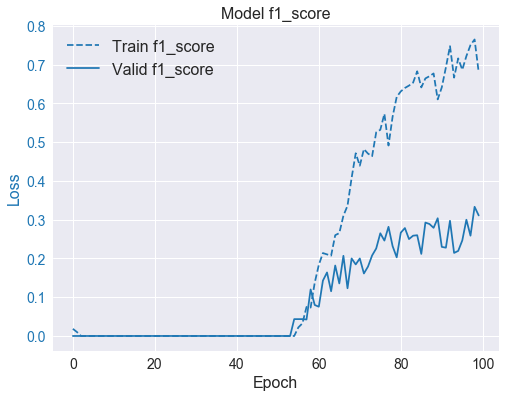

In [209]:
plt, fig = plot_metric(history, metric='f1_score')
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

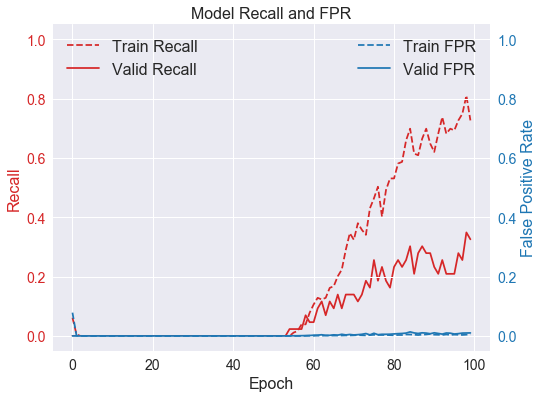

In [211]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### 2.2. Dropout + return_sequences=True

In [212]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
dropout_22 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_14 (Flatten)         (None, 40)                0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
___________________________________________________

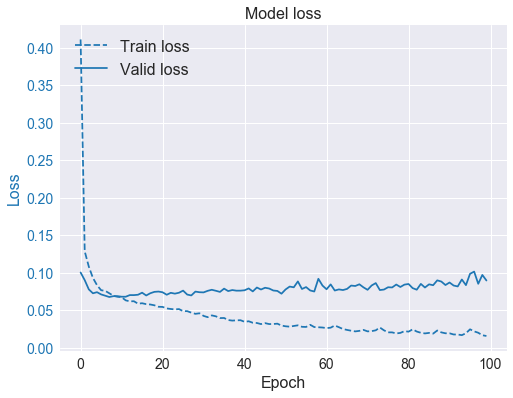

In [213]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

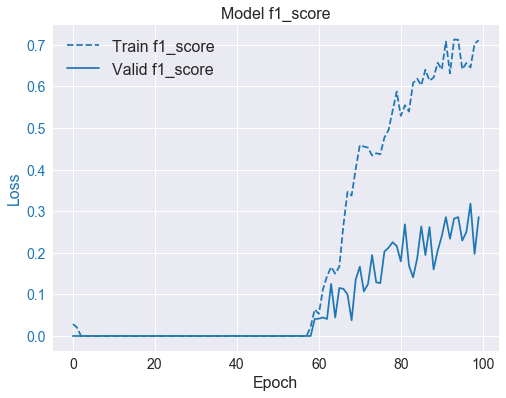

In [214]:
plt, fig = plot_metric(history, metric='f1_score')
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

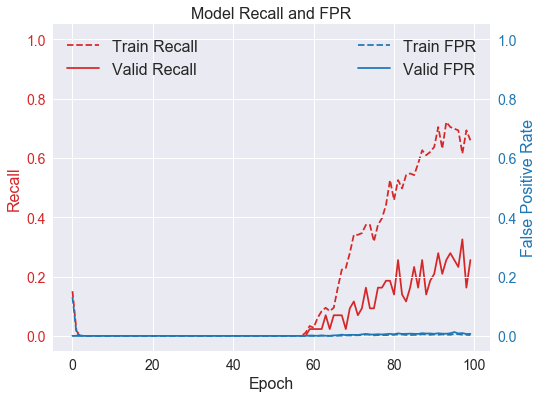

In [215]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 3.1. Larger layer with recurrent_dropout

In [234]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.5, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(16, activation='relu', return_sequences=False, recurrent_dropout=0.5, name='lstm_layer_2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 32)             13056     
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 16)                3136      
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 16,209
Trainable params: 16,209
Non-trainable params: 0
_________________________________________________________________


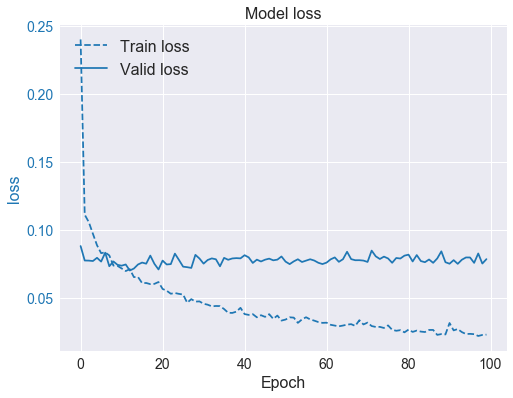

In [235]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

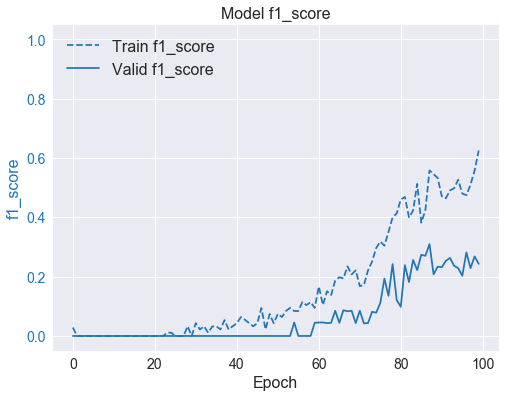

In [236]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

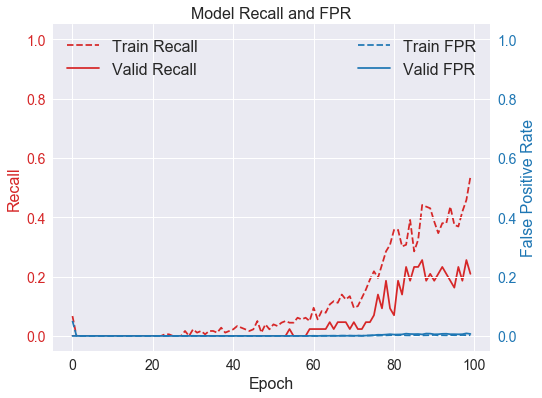

In [237]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### 3.2. Larger layer with recurrent_dropout + Flatten()

In [238]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.5, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(16, activation='relu', return_sequences=True, recurrent_dropout=0.5, name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 32)             13056     
_________________________________________________________________
dropout_30 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 16)             3136      
_________________________________________________________________
flatten_16 (Flatten)         (None, 80)                0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 16,273
Trainable params: 16,273
Non-trainable params: 0
_________________________________________________

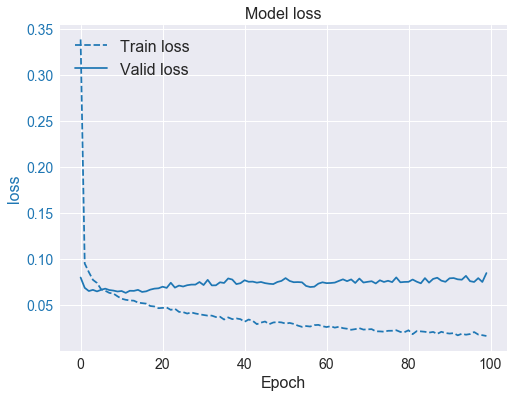

In [239]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

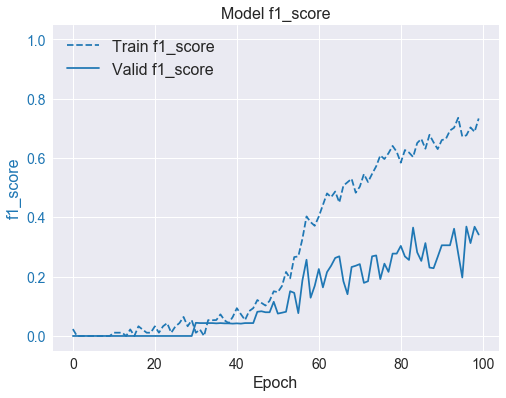

In [240]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

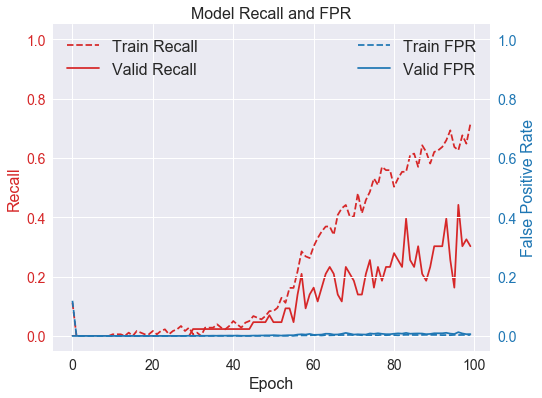

In [241]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 4.1. go_backwards=True

In [221]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(8, activation='relu', return_sequences=False, go_backwards=True, name='lstm_layer_2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
dropout_26 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 8)                 800       
_________________________________________________________________
dropout_27 (Dropout)         (None, 8)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 6,313
Trainable params: 6,313
Non-trainable params: 0
_________________________________________________________________


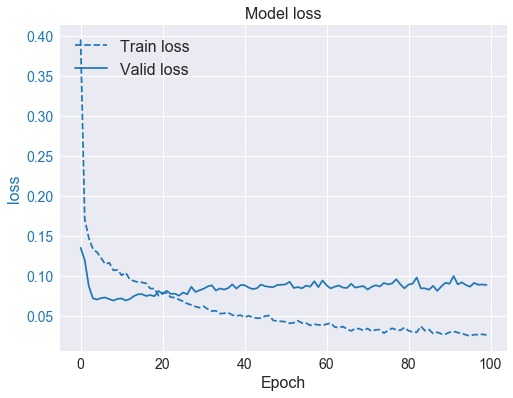

In [222]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

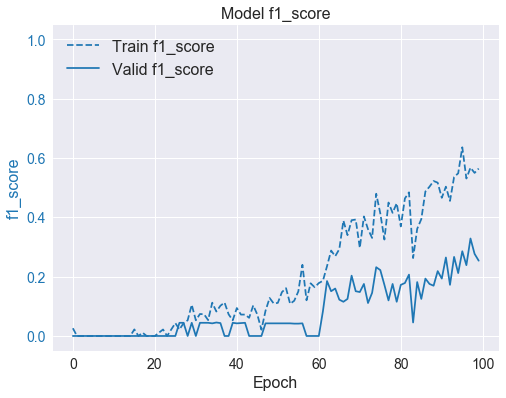

In [232]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

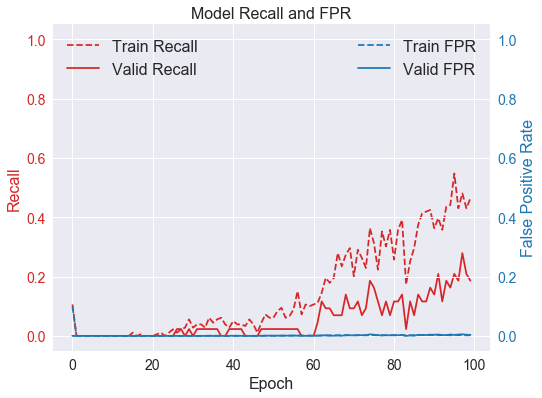

In [229]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 4.2. go_backwards=True and Flatten()

In [217]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    LSTM(16, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(8, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
dropout_24 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_15 (Flatten)         (None, 40)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
___________________________________________________

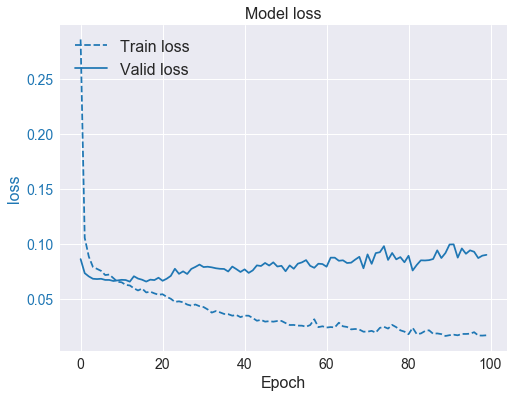

In [218]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

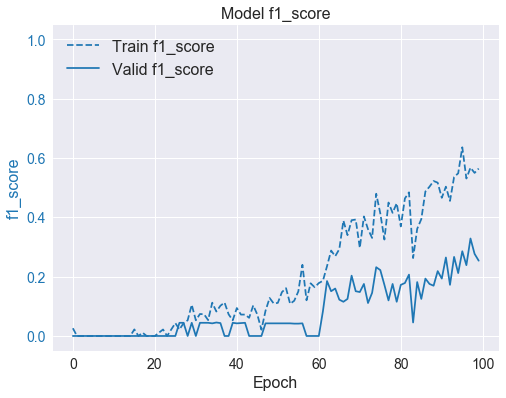

In [233]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

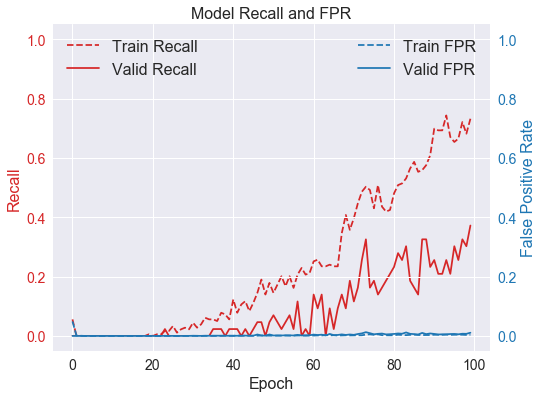

In [220]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 5.1. Bidirectional.

go_backwards not required.

In [243]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    Bidirectional(
        LSTM(16, activation='relu', return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(8, activation='relu', return_sequences=False,
             name='lstm_layer_2')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 32)             11008     
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 13,649
Trainable params: 13,649
Non-trainable params: 0
_________________________________________________________________


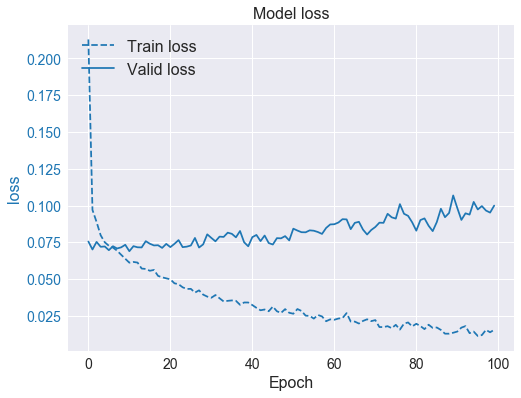

In [244]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

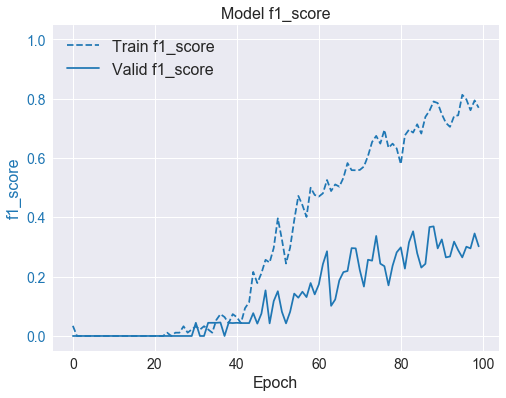

In [245]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

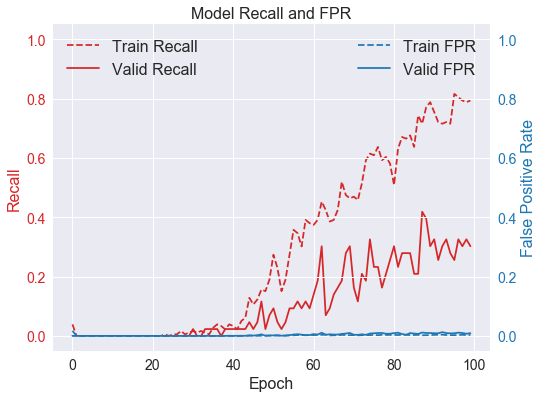

In [246]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 5.2. Bidirectional + flatten()

In [247]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    Bidirectional(
        LSTM(16, activation='relu', return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(8, activation='relu', return_sequences=True,
             name='lstm_layer_2')))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 5, 32)             11008     
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 5, 16)             2624      
_________________________________________________________________
flatten_17 (Flatten)         (None, 80)                0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 13,713
Trainable params: 13,713
Non-trainable params: 0
_________________________________________________

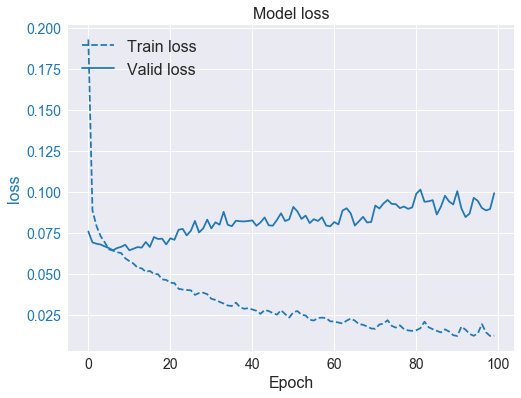

In [248]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

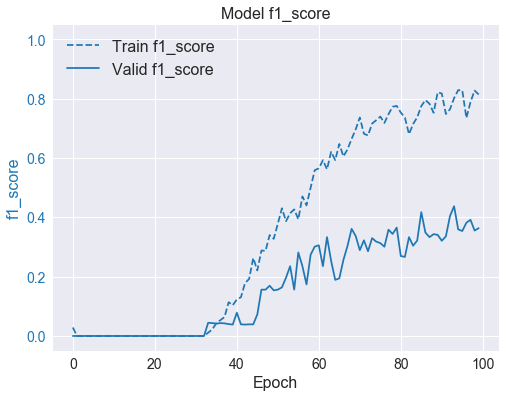

In [249]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

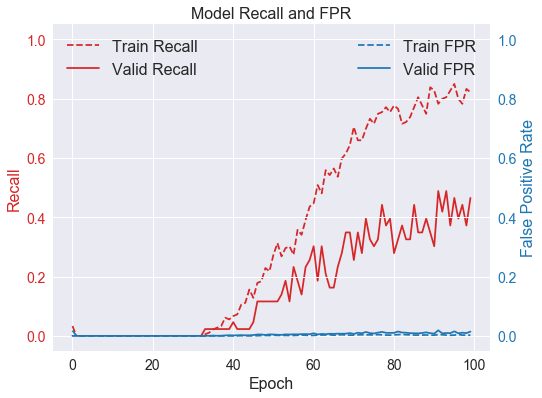

In [250]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 6.1. SELU + Bidirectional + flatten()

In [251]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    Bidirectional(
        LSTM(16, activation='selu', return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(8, activation='selu', return_sequences=True,
             name='lstm_layer_2')))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 5, 32)             11008     
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 16)             2624      
_________________________________________________________________
flatten_18 (Flatten)         (None, 80)                0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 13,713
Trainable params: 13,713
Non-trainable params: 0
_________________________________________________

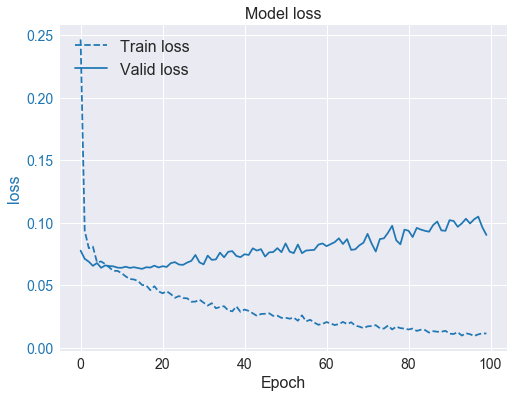

In [252]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

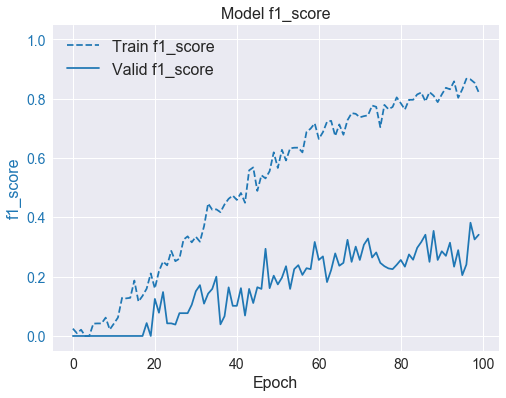

In [253]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

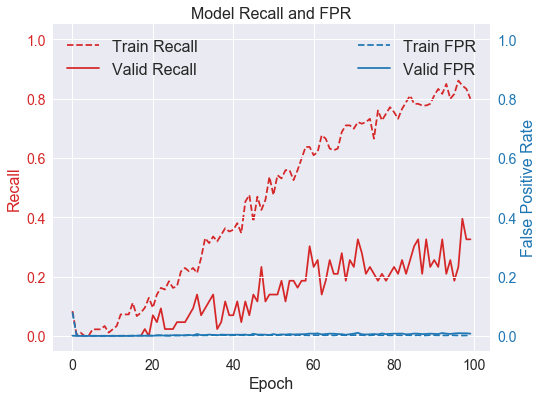

In [254]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 6.1. tanh + Bidirectional + flatten()

In [267]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    Bidirectional(
        LSTM(16, activation='tanh', return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(8, activation='tanh', return_sequences=True,
             name='lstm_layer_2')))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 5, 32)             11008     
_________________________________________________________________
dropout_40 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 5, 16)             2624      
_________________________________________________________________
flatten_20 (Flatten)         (None, 80)                0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 13,713
Trainable params: 13,713
Non-trainable params: 0
_________________________________________________

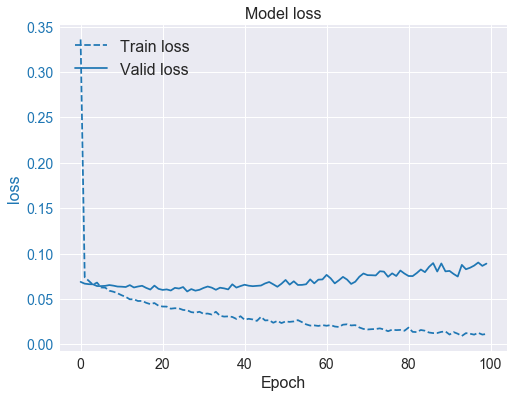

In [268]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

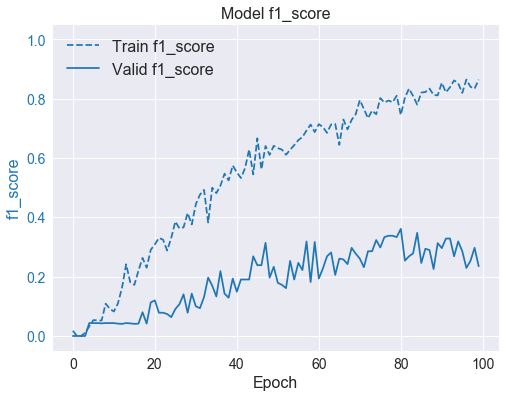

In [269]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

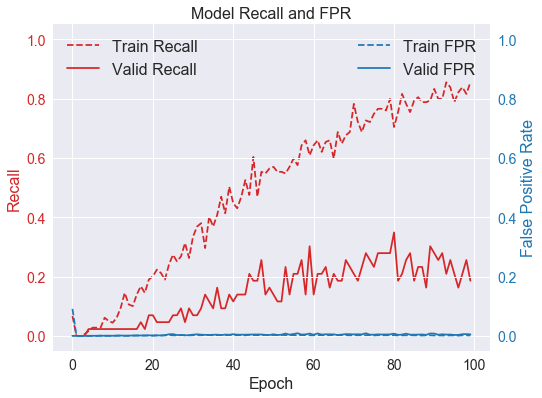

In [270]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 7.1. Longer lookback + bidrectional + flatten

In [287]:
lookback = 20  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)

X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

X_train_scaled = scale(X_train, scaler)

X_valid_scaled = scale(X_valid, scaler)
X_test_scaled = scale(X_test, scaler)

In [288]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(
    Bidirectional(
        LSTM(16, activation='relu', return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(8, activation='relu', return_sequences=True,
             name='lstm_layer_2')))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 20, 32)            11008     
_________________________________________________________________
dropout_42 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20, 16)            2624      
_________________________________________________________________
flatten_24 (Flatten)         (None, 320)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 320)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 321       
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________

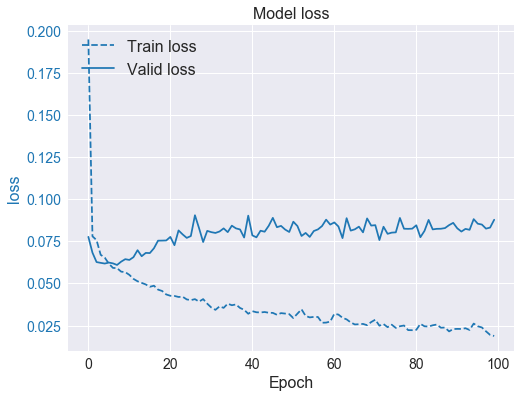

In [289]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

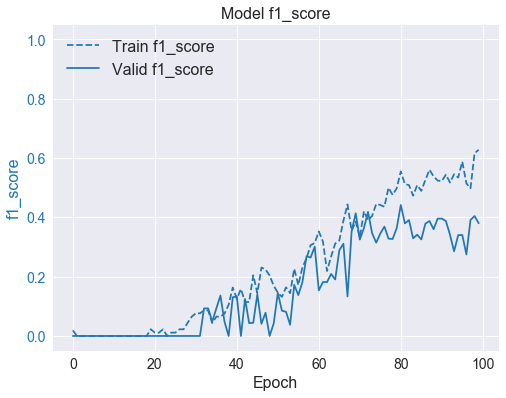

In [290]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

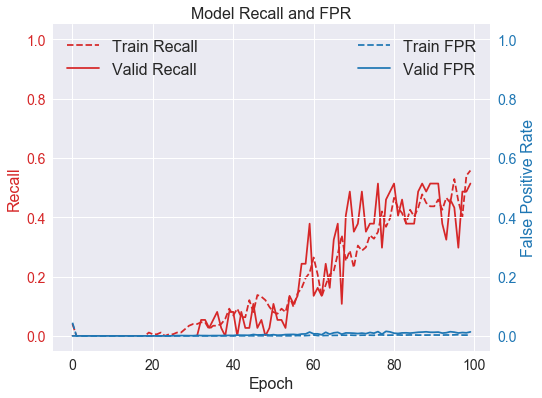

In [291]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

# TODO:
Increase the epochs in the final model.

# CNN Models

With the longer lookback, let's get into the CNN model.

### Model 1.1. Baseline CNN 1 layer.

In [375]:
timesteps = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid', name='output'))
model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


In [313]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


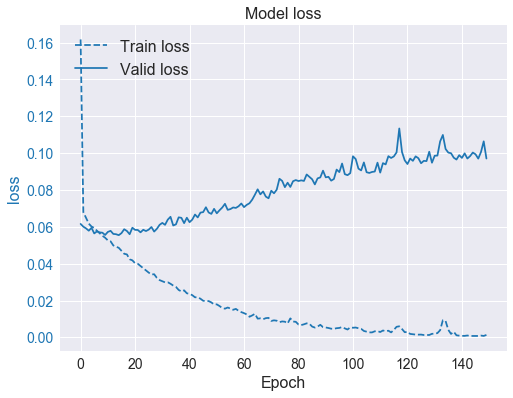

In [314]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_one_layer_loss.pdf', bbox_inches='tight')

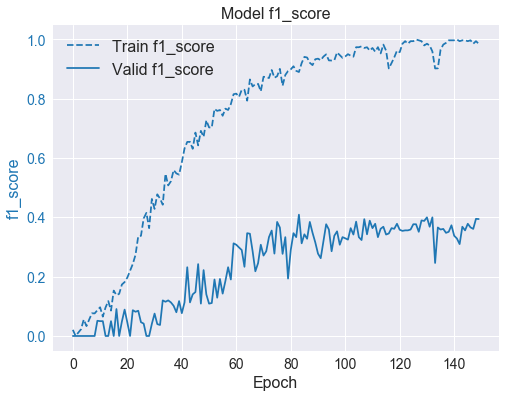

In [315]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_one_layer_f1_score.pdf', bbox_inches='tight')

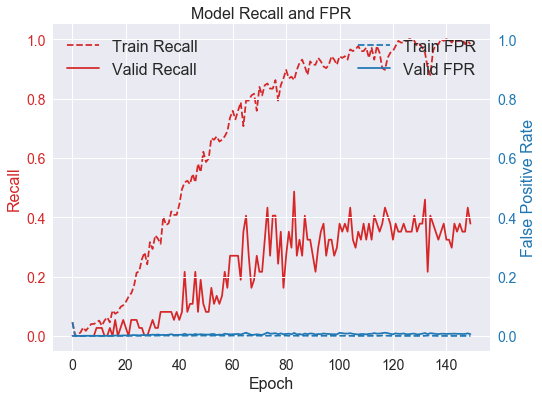

In [316]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_one_layer_recall_fpr.pdf', bbox_inches='tight')

### Model 1.2. Baseline CNN 2 layer

In [376]:
timesteps = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Conv1D(filters=8, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 3, 8)              264       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 1, 8)              0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 8)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
___________________________________________________

In [328]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  F1Score(),
                  FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 3, 16)             528       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 16)             0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 4,977
Trainable params: 4,977
Non-trainable params: 0
___________________________________________________

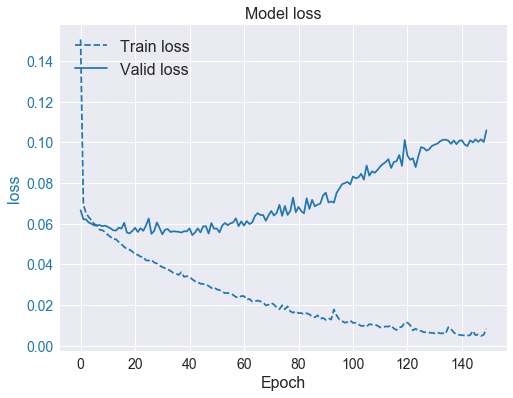

In [329]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_two_layer_loss.pdf', bbox_inches='tight')

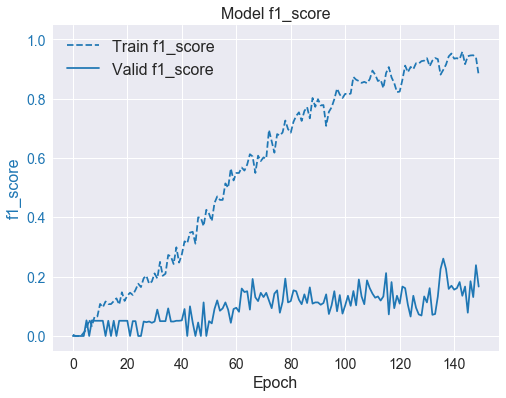

In [330]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_two_layer_f1_score.pdf', bbox_inches='tight')

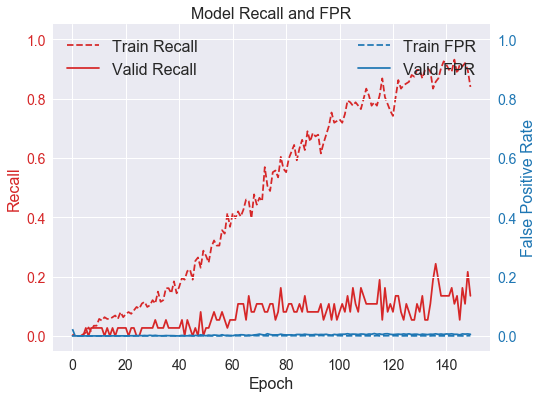

In [331]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_two_layer_recall_fpr.pdf', bbox_inches='tight')

### Model 1.3. CNN + Dropout

In [351]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Dropout(0.5))
# model.add(
#     LSTM(16, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_1'))
# model.add(Dropout(0.5))
# model.add(
#     LSTM(8, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_2'))
# model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=150,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)               

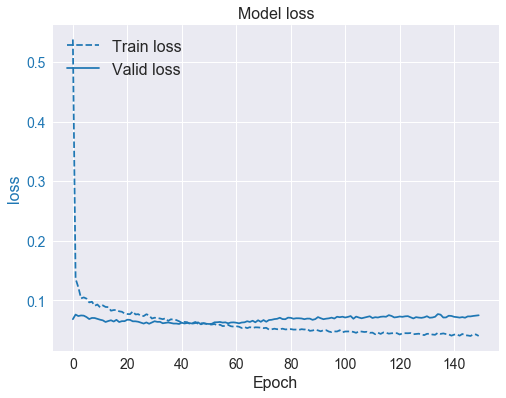

In [352]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

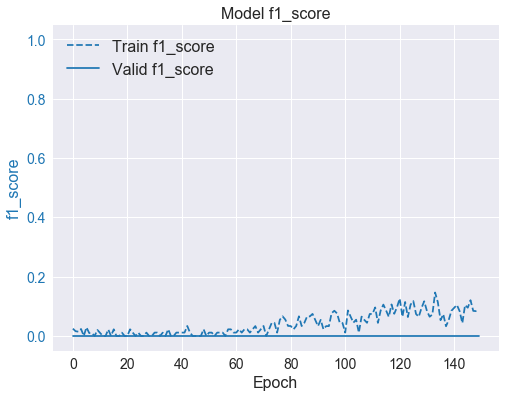

In [353]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

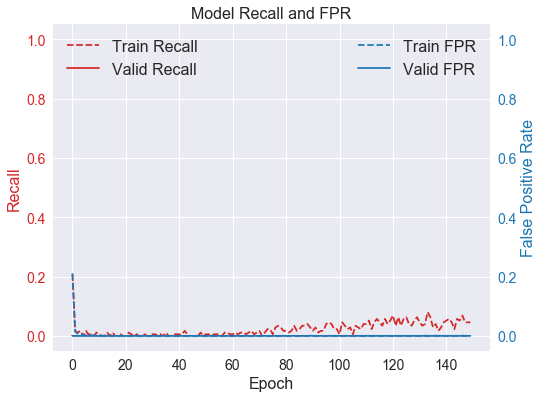

In [354]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 1.4. CNN + kernel regularizer

In [363]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPool1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=150,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


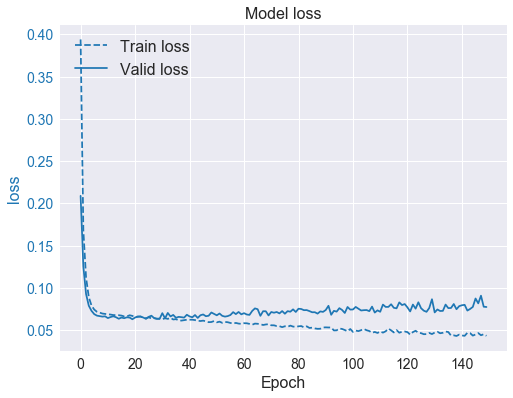

In [364]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

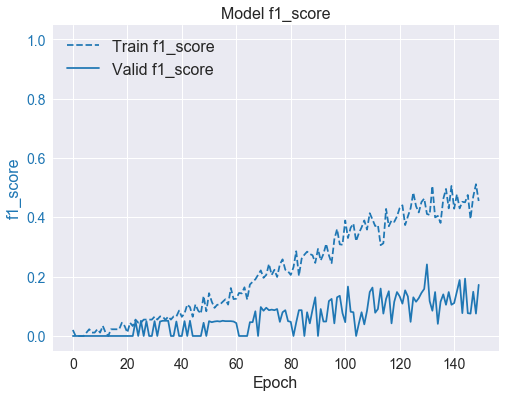

In [365]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

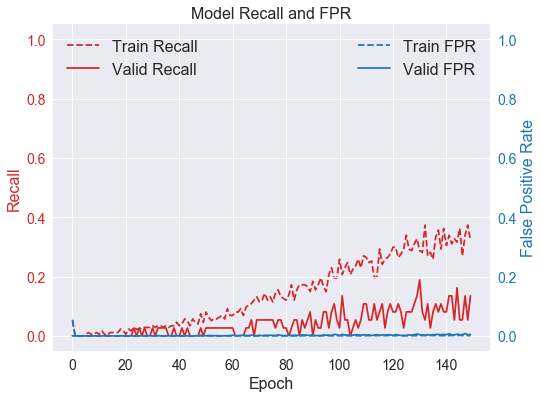

In [366]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 2.1. LSTM 1 layer + CNN 1 layer.

In [322]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_1'))
# model.add(Dropout(0.5))
# model.add(
#     LSTM(8, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_2'))
# model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=150,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 4, 8)              800       
_________________________________________________________________
flatten_33 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
___________________________________________________

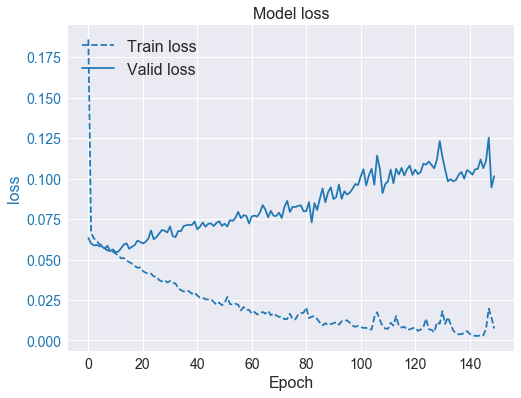

In [323]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

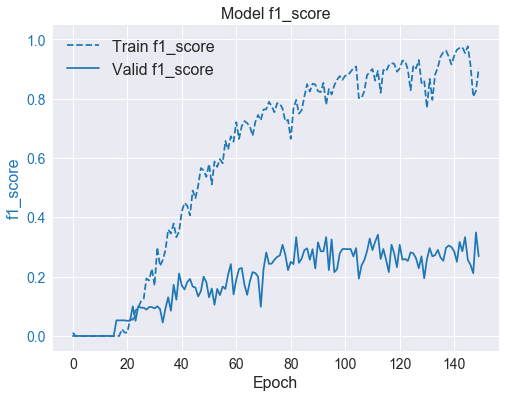

In [324]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

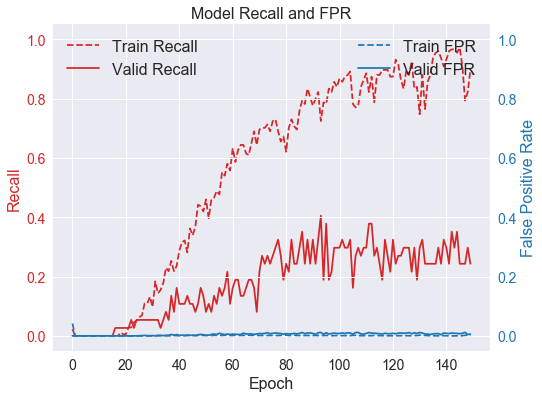

In [325]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 2.1. LSTM 2 layer + CNN 1 layer.

In [334]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(
    LSTM(4, activation='relu', return_sequences=True, name='lstm_layer_2'))



# model.add(Dropout(0.5))
# model.add(
#     LSTM(8, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_2'))
# model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=150,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 4, 8)              800       
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 4, 4)              208       
_________________________________________________________________
flatten_38 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)               

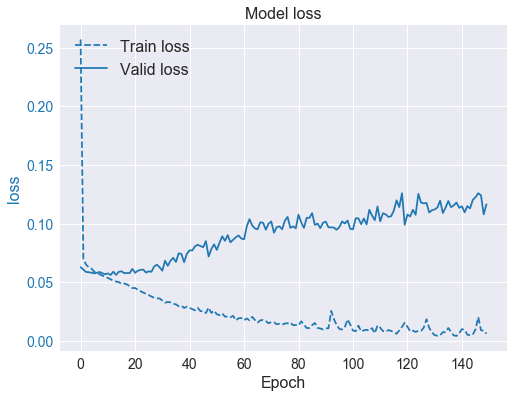

In [335]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

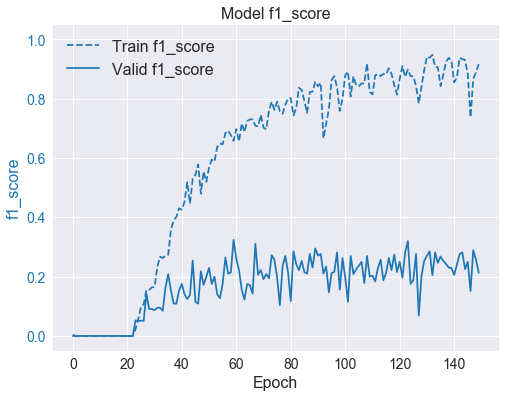

In [336]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

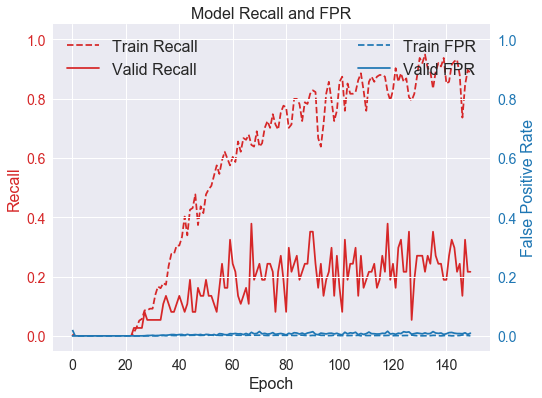

In [337]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

### Model 3. CNN + LSTM + dropout

In [371]:
timesteps = X_train_scaled.shape[1]  # equal to the lookback
n_features = X_train_scaled.shape[2]  # 69

model = Sequential()
model.add(Input(shape=(timesteps, n_features), name='input'))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Dropout(0.5))
model.add(
    LSTM(8, activation='relu', return_sequences=True, name='lstm_layer_1'))
model.add(Dropout(0.5))
# model.add(
#     LSTM(8, activation='relu', return_sequences=True, go_backwards=True, name='lstm_layer_2'))
# model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(), 
                     F1Score(),
                     FalsePositiveRate()]
           )
history = model.fit(x=X_train_scaled,
                  y=y_train,
                  batch_size=128,
                  epochs=150,
                  validation_data=(X_valid_scaled, y_valid),
                  verbose=0).history

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 4, 8)              800       
_________________________________________________________________
flatten_48 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
___________________________________________________

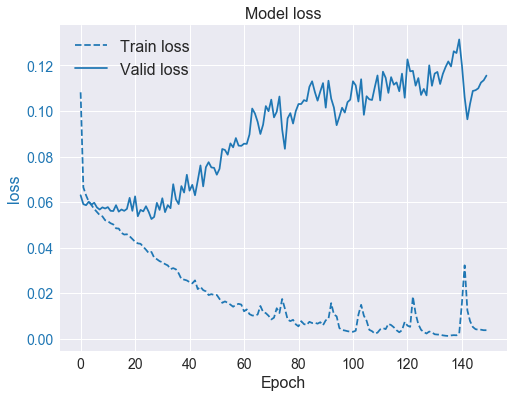

In [372]:
plt, fig = plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

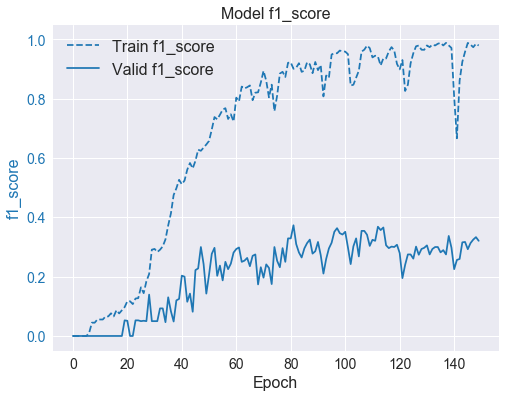

In [373]:
plt, fig = plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

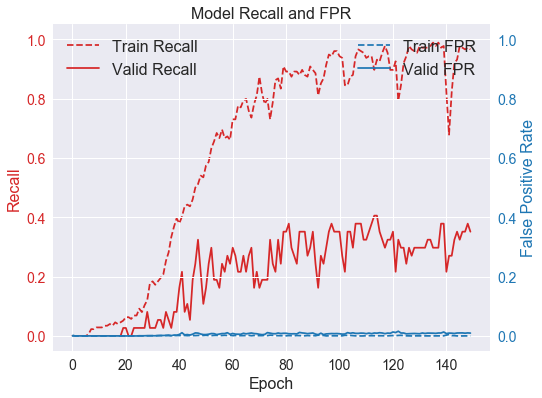

In [374]:
plt, fig = plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')